# [**Codage creux avec un dictionnaire précalculé**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_5_decomposition/plot_sparse_coding.ipynb)<br/>([*Sparse coding with a precomputed dictionary*](https://scikit-learn.org/stable/auto_examples/decomposition/plot_sparse_coding.html))

Transformez un signal en une combinaison creuse d'ondelettes de Ricker. Cet exemple compare visuellement différentes méthodes de codage creux en utilisant l'estimateur [**`SparseCoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparseCoder.html). Le Ricker (aussi connu sous le nom de chapeau mexicain ou la seconde dérivée d'une gaussienne) n'est pas un noyau particulièrement adapté pour représenter des signaux constants par morceaux comme celui-ci. On peut donc voir à quel point l'ajout de différentes largeurs d'atomes est important, ce qui motive l'apprentissage du dictionnaire pour mieux s'adapter à votre type de signaux.

Le dictionnaire plus riche à droite n'est pas plus grand en taille, un sous-échantillonnage plus important est effectué afin de rester sur le même ordre de grandeur.

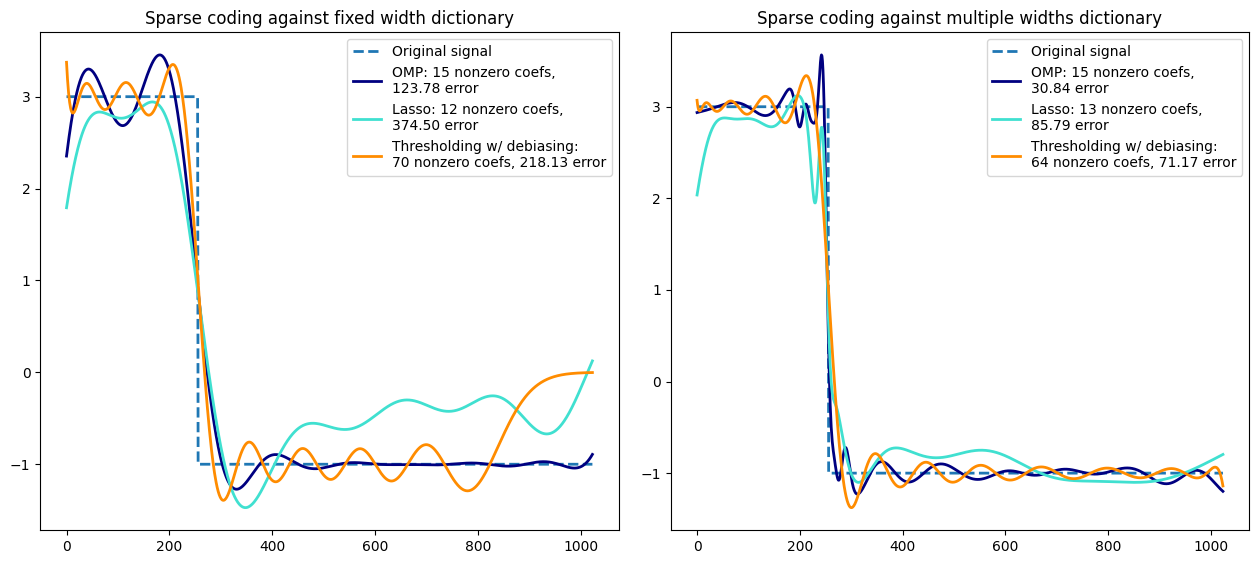

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import SparseCoder


def ricker_function(resolution, center, width):
    """Discrete sub-sampled Ricker (Mexican hat) wavelet"""
    x = np.linspace(0, resolution - 1, resolution)
    x = (
        (2 / (np.sqrt(3 * width) * np.pi**0.25))
        * (1 - (x - center) ** 2 / width**2)
        * np.exp(-((x - center) ** 2) / (2 * width**2))
    )
    return x


def ricker_matrix(width, resolution, n_components):
    """Dictionary of Ricker (Mexican hat) wavelets"""
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D**2, axis=1))[:, np.newaxis]
    return D


resolution = 1024
subsampling = 3  # subsampling factor
width = 100
n_components = resolution // subsampling

# Compute a wavelet dictionary
D_fixed = ricker_matrix(width=width, resolution=resolution, n_components=n_components)
D_multi = np.r_[
    tuple(
        ricker_matrix(width=w, resolution=resolution, n_components=n_components // 5)
        for w in (10, 50, 100, 500, 1000)
    )
]

# Generate a signal
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3.0
y[np.logical_not(first_quarter)] = -1.0

# List the different sparse coding methods in the following format:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)
estimators = [
    ("OMP", "omp", None, 15, "navy"),
    ("Lasso", "lasso_lars", 2, None, "turquoise"),
]
lw = 2

plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(
    zip((D_fixed, D_multi), ("fixed width", "multiple widths"))
):
    plt.subplot(1, 2, subplot + 1)
    plt.title("Sparse coding against %s dictionary" % title)
    plt.plot(y, lw=lw, linestyle="--", label="Original signal")
    # Do a wavelet approximation
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(
            dictionary=D,
            transform_n_nonzero_coefs=n_nonzero,
            transform_alpha=alpha,
            transform_algorithm=algo,
        )
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(
            x,
            color=color,
            lw=lw,
            label="%s: %s nonzero coefs,\n%.2f error" % (title, density, squared_error),
        )

    # Soft thresholding debiasing
    coder = SparseCoder(
        dictionary=D, transform_algorithm="threshold", transform_alpha=20
    )
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=None)
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    plt.plot(
        x,
        color="darkorange",
        lw=lw,
        label="Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error"
        % (len(idx), squared_error),
    )
    plt.axis("tight")
    plt.legend(shadow=False, loc="best")
plt.subplots_adjust(0.04, 0.07, 0.97, 0.90, 0.09, 0.2)
plt.show()